In [215]:
#Libraries
import os
import pandas as pd
import librosa
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt

In [190]:
#Listing files
filelist = os.listdir("Source")

#Read files into pandas
source = pd.DataFrame(filelist)

#Rename file name column
source = source.rename(columns={0:'file'})

#Display files
source

,file
0,03-01-06-01-02-02-02.wav
1,03-01-05-01-02-01-16.wav
2,03-01-08-01-01-01-14.wav
3,03-01-06-01-02-02-16.wav
4,03-01-05-01-02-01-02.wav
...,...
1436,03-01-08-02-02-01-19.wav
1437,03-01-02-02-01-01-23.wav
1438,03-01-02-01-02-01-23.wav
1439,03-01-08-01-01-01-19.wav


In [191]:
#Extract speaker id from files
speaker_id = []

for i in range (0, len(source)):
    id = source["file"][i][18:20]
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
#Add speaker id to dataframe
source["id"] = speaker_id

source

,file,id
0,03-01-06-01-02-02-02.wav,2
1,03-01-05-01-02-01-16.wav,16
2,03-01-08-01-01-01-14.wav,14
3,03-01-06-01-02-02-16.wav,16
4,03-01-05-01-02-01-02.wav,2
...,...,...
1436,03-01-08-02-02-01-19.wav,19
1437,03-01-02-02-01-01-23.wav,23
1438,03-01-02-01-02-01-23.wav,23
1439,03-01-08-01-01-01-19.wav,19


In [192]:
#Create training dataframe
train = pd.DataFrame()

for i in range (1, 25):
    tmp = source[(source.id==str(i))]
    tmp.reset_index(drop=True, inplace=True)
    train = train.append(tmp.sample(6), ignore_index=True)

train

,file,id
0,03-01-03-02-02-02-01.wav,1
1,03-01-01-01-02-02-01.wav,1
2,03-01-04-02-02-01-01.wav,1
3,03-01-03-01-01-02-01.wav,1
4,03-01-01-01-02-01-01.wav,1
...,...,...
139,03-01-03-02-01-02-24.wav,24
140,03-01-06-02-02-01-24.wav,24
141,03-01-08-01-02-02-24.wav,24
142,03-01-02-01-02-02-24.wav,24


In [193]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath("Source")+'/'+str(files.file))# Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')# Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)# Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))# Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)# Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)# Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)# Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    
    return mfccs, chroma, mel, contrast, tonnetz

In [194]:
train_features = train.apply(extract_features, axis=1)
train_features

0      ([-542.5081, 54.40278, -13.658028, 11.467112, ...
1      ([-687.51337, 59.44154, -0.703714, 16.645708, ...
2      ([-622.66144, 58.43044, -9.114211, 17.023947, ...
3      ([-633.64465, 66.22681, -8.990109, 18.561934, ...
4      ([-694.00433, 61.49651, -3.2627435, 16.971298,...
                             ...                        
139    ([-529.7651, 36.954094, -23.506788, 13.687335,...
140    ([-457.59335, 9.347517, -29.394049, -7.0981655...
141    ([-589.9005, 29.791267, -22.180174, 2.9369574,...
142    ([-697.4625, 46.14912, -2.2105117, 5.662385, -...
143    ([-689.29297, 46.676765, -10.846545, 4.3588014...
Length: 144, dtype: object

In [195]:
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))

In [196]:
X_train = np.array(features_train)

In [197]:
y_train = np.array(train["id"])
print(y_train)
#y_val = np.array(val_df['speaker'])

['1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '3'
 '4' '4' '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '6'
 '7' '7' '7' '7' '7' '7' '8' '8' '8' '8' '8' '8' '9' '9' '9' '9' '9' '9'
 '10' '10' '10' '10' '10' '10' '11' '11' '11' '11' '11' '11' '12' '12'
 '12' '12' '12' '12' '13' '13' '13' '13' '13' '13' '14' '14' '14' '14'
 '14' '14' '15' '15' '15' '15' '15' '15' '16' '16' '16' '16' '16' '16'
 '17' '17' '17' '17' '17' '17' '18' '18' '18' '18' '18' '18' '19' '19'
 '19' '19' '19' '19' '20' '20' '20' '20' '20' '20' '21' '21' '21' '21'
 '21' '21' '22' '22' '22' '22' '22' '22' '23' '23' '23' '23' '23' '23'
 '24' '24' '24' '24' '24' '24']


In [198]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical# Hot encoding y
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
#y_val = to_categorical(lb.fit_transform(y_train))

In [201]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
#X_val = ss.transform(X_val)
#X_test = ss.transform(X_test)

In [207]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 30 classes
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [208]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    callbacks=[early_stop])

Epoch 1/100
144/144 [==============================] - 1s 7ms/step - loss: 3.5970 - accuracy: 0.0486
Epoch 2/100
144/144 [==============================] - 0s 96us/step - loss: 3.4605 - accuracy: 0.0208
Epoch 3/100
144/144 [==============================] - 0s 95us/step - loss: 3.2600 - accuracy: 0.0556
Epoch 4/100
144/144 [==============================] - 0s 89us/step - loss: 3.2113 - accuracy: 0.0347
Epoch 5/100
144/144 [==============================] - 0s 95us/step - loss: 3.1554 - accuracy: 0.0556
Epoch 6/100
144/144 [==============================] - 0s 90us/step - loss: 3.0753 - accuracy: 0.0833
Epoch 7/100
144/144 [==============================] - 0s 126us/step - loss: 3.0136 - accuracy: 0.1042
Epoch 8/100
144/144 [==============================] - 0s 86us/step - loss: 2.9411 - accuracy: 0.1389
Epoch 9/100
144/144 [==============================] - 0s 84us/step - loss: 2.8834 - accuracy: 0.1042
Epoch 10/100
144/144 [==============================] - 0s 86us/step - loss: 2.869

/Users/jthiepler/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



144/144 [==============================] - 0s 98us/step - loss: 2.6593 - accuracy: 0.2500
Epoch 16/100
144/144 [==============================] - 0s 101us/step - loss: 2.5650 - accuracy: 0.3264
Epoch 17/100
144/144 [==============================] - 0s 106us/step - loss: 2.5172 - accuracy: 0.2778
Epoch 18/100
144/144 [==============================] - 0s 89us/step - loss: 2.5155 - accuracy: 0.3611
Epoch 19/100
144/144 [==============================] - 0s 87us/step - loss: 2.4659 - accuracy: 0.3750
Epoch 20/100
144/144 [==============================] - 0s 86us/step - loss: 2.4768 - accuracy: 0.3056
Epoch 21/100
144/144 [==============================] - 0s 81us/step - loss: 2.4587 - accuracy: 0.3194
Epoch 22/100
144/144 [==============================] - 0s 82us/step - loss: 2.3483 - accuracy: 0.3472
Epoch 23/100
144/144 [==============================] - 0s 87us/step - loss: 2.3551 - accuracy: 0.3264
Epoch 24/100
144/144 [==============================] - 0s 88us/step - loss: 2.2786

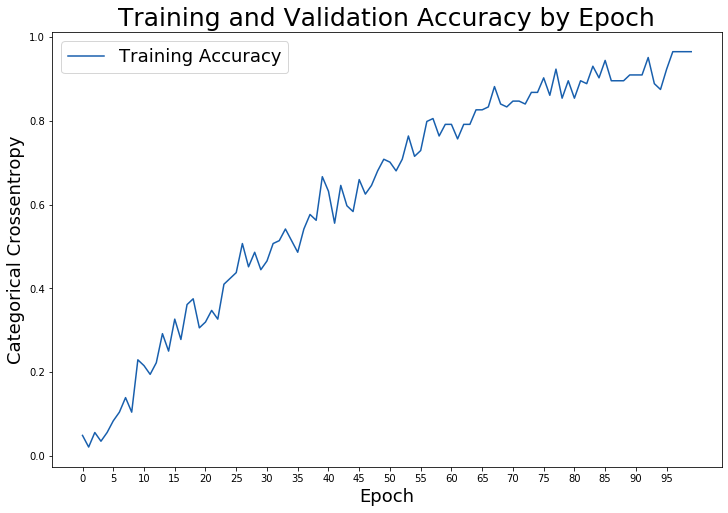

In [216]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']# Set figure size.
plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
#plt.plot(val_accuracy, label='Validation Accuracy', color='orange')# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);